In [58]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import string
from wordcloud import WordCloud
from scipy.stats import randint
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [59]:
!pip freeze

anyio==4.0.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
asttokens==2.4.0
async-lru==2.0.4
attrs==23.1.0
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.0.0
certifi==2023.7.22
cffi==1.15.1
charset-normalizer==3.2.0
click==8.1.7
colorama==0.4.6
comm==0.1.4
contourpy==1.1.1
cycler==0.11.0
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
executing==1.2.0
fastjsonschema==2.18.0
fonttools==4.42.1
fqdn==1.5.1
idna==3.4
ipykernel==6.25.2
ipython==8.15.0
ipython-genutils==0.2.0
ipywidgets==8.1.1
isoduration==20.11.0
jedi==0.19.0
Jinja2==3.1.2
joblib==1.3.2
json5==0.9.14
jsonpointer==2.4
jsonschema==4.19.0
jsonschema-specifications==2023.7.1
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.7.0
jupyter-lsp==2.2.0
jupyter_client==8.3.1
jupyter_core==5.3.1
jupyter_server==2.7.3
jupyter_server_terminals==0.4.4
jupyterlab==4.0.5
jupyterlab-pygments==0.2.2
jupyterlab-widgets==3.0.9
jupyterlab_server==2.25.0
kiwisolver==1.4.5
MarkupSafe==2.1.3
matplotlib==3.8.0

In [60]:
#data_encoded="ISO-8859-1"
data = pd.read_csv('Reddit-ADPS-Data_2.csv',encoding= 'unicode_escape')

In [61]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8330 entries, 0 to 8329
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   post        8315 non-null   object 
 1   topics      8330 non-null   object 
 2   Unnamed: 2  0 non-null      float64
 3   Unnamed: 3  4 non-null      object 
dtypes: float64(1), object(3)
memory usage: 260.4+ KB


In [62]:
#Renaming categories
data.replace({'topics':
    {'anxiety':'Anxiety',
    'depression':'Depression',
    'ptsd':'PTSD',
    'socialanxiety':'Social Anxiety',
    'suicidewatch':'Suicidal thoughts',
    }},inplace=True)
pd.DataFrame(data.topics.unique()).values

array([['Anxiety'],
       ['Depression'],
       ['PTSD'],
       ['Social Anxiety'],
       ['Suicidal thoughts']], dtype=object)

In [63]:
data.describe()
#data.head()

,Unnamed: 2
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [64]:
#REMOVING COLUMNS
data.drop(columns=['Unnamed: 2','Unnamed: 3'],inplace=True)

In [65]:
data=data.dropna()
data.isnull().sum()


post      0
topics    0
dtype: int64

In [66]:
data.describe()

,post,topics
count,8315,8315
unique,8227,5
top,"""No regrets or grudges/angry at things that ha...",Anxiety
freq,5,1666


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8315 entries, 0 to 8329
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   post    8315 non-null   object
 1   topics  8315 non-null   object
dtypes: object(2)
memory usage: 194.9+ KB


In [68]:
display(data)

,post,topics
0,Does anyone else get anxious with working? im ...,Anxiety
1,Help with anxiety-inducing fears about school ...,Anxiety
2,Use up what's left and throw the rest away I r...,Anxiety
3,My brain is driving me crazy! Im a perfectioni...,Anxiety
4,Does anyone else feel like the worst person ev...,Anxiety
...,...,...
8325,"alone, useless and horribly guilty reaching ou...",Suicidal thoughts
8326,Am I not understanding/seeing something? This ...,Suicidal thoughts
8327,Just a bad day So today has been a stressful d...,Suicidal thoughts
8328,When Im dead maybe the suffering will all come...,Suicidal thoughts


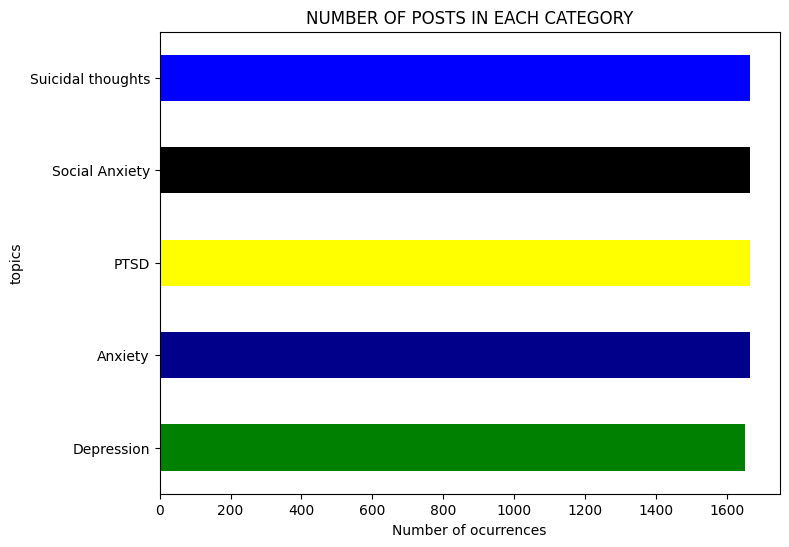

In [69]:
fig = plt.figure(figsize=(8,6))
colors = ['green','darkblue','yellow',
    'black','blue','orange']
data.groupby('topics').post.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF POSTS IN EACH CATEGORY')
plt.xlabel('Number of ocurrences', fontsize = 10);

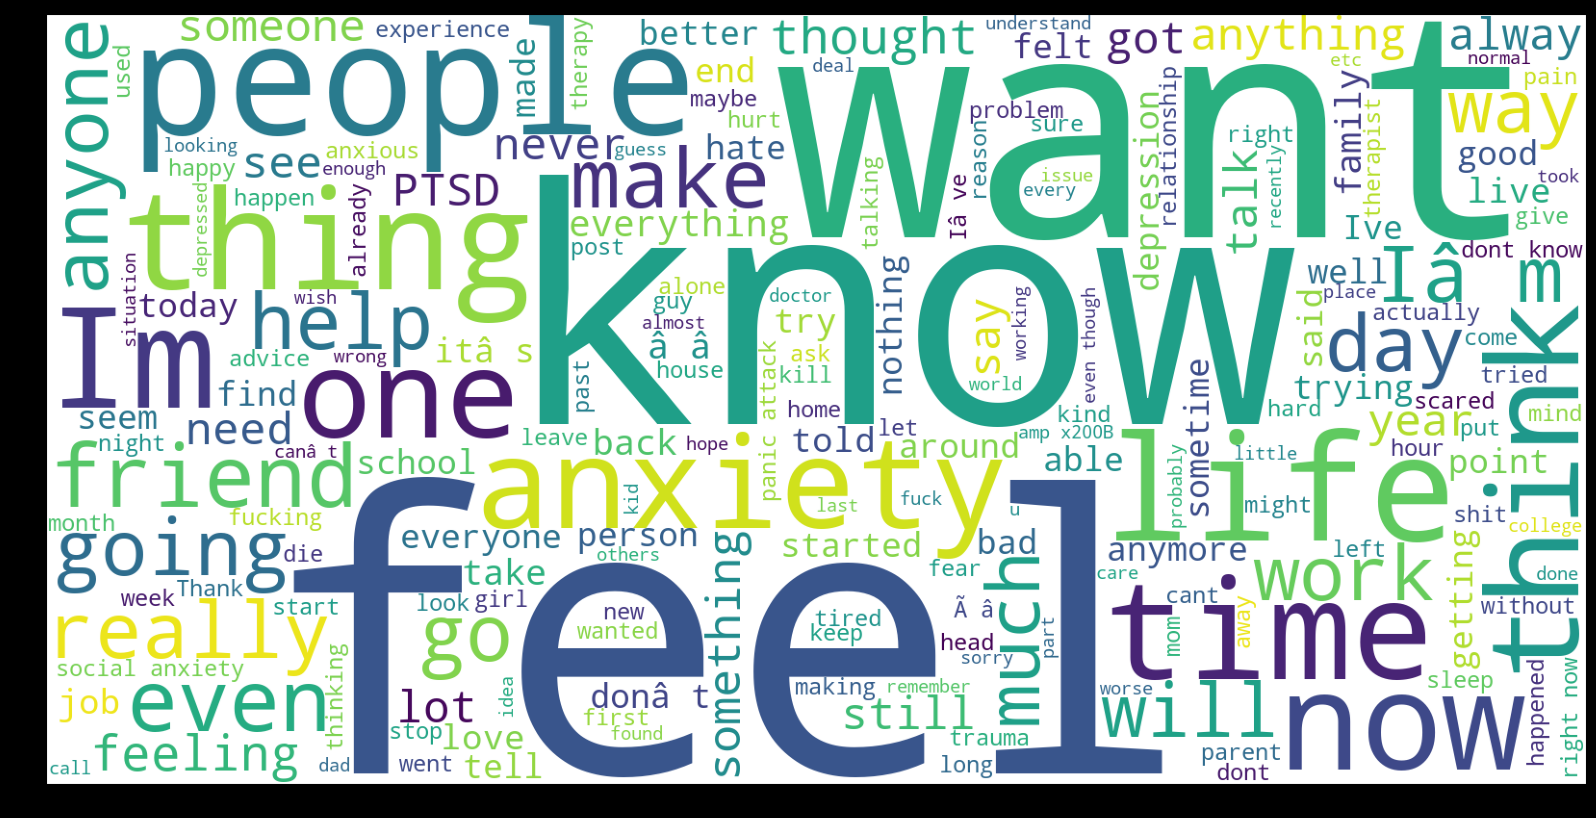

In [70]:
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(data['post'].tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

In [71]:
#Now, we will map each of these categories to a number, so that our model can understand it in a better way and we will save this in a new column named ‘category_id’. Where each of the 5 categories is represented in numerical.
# Create a new column 'category_id' with encoded categories 
data['category_id'] = data['topics'].factorize()[0]
category_id_df = data[['topics', 'category_id']].drop_duplicates()
print(category_id_df)

                 topics  category_id
0               Anxiety            0
1666         Depression            1
3332               PTSD            2
4998     Social Anxiety            3
6664  Suicidal thoughts            4


In [72]:
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'topics']].values)

In [73]:
print(category_to_id)
print(id_to_category)

{'Anxiety': 0, 'Depression': 1, 'PTSD': 2, 'Social Anxiety': 3, 'Suicidal thoughts': 4}
{0: 'Anxiety', 1: 'Depression', 2: 'PTSD', 3: 'Social Anxiety', 4: 'Suicidal thoughts'}


In [74]:
#!pip install --upgrade <package_name>

In [75]:
def wl(text):
    return len(text.split(" "))
data['word_length']=data['post'].apply(wl)

<Axes: >

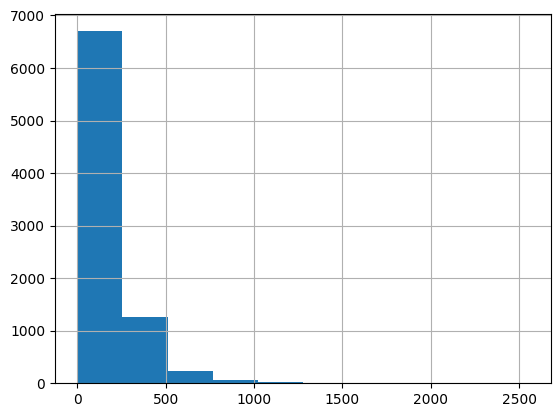

In [76]:
#Now plotting the word_length,as shown below most of the words in a sentence are between 8 and 22.#
data['word_length'].hist()

In [77]:

data['unique_word_count'] =data['post'].apply(lambda x: len(set(str(x).split())))

<Axes: >

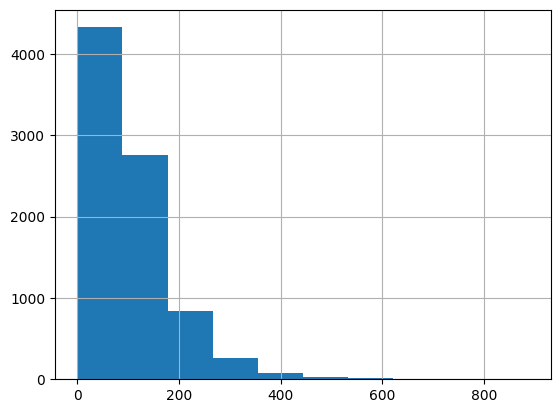

In [78]:
data['unique_word_count'].hist()

In [79]:
#Below is th simple code to get bigrams from text.
nltk.download('punkt')
from nltk.util import ngrams
def get_bigram(text):
    big=''
    token = nltk.word_tokenize(text)
    big=(list(ngrams(token, 2)))
    return str(big)    
data['bigram']=data['post'].apply(get_bigram)
data['bigram']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0       [('Does', 'anyone'), ('anyone', 'else'), ('els...
1       [('Help', 'with'), ('with', 'anxiety-inducing'...
2       [('Use', 'up'), ('up', 'what'), ('what', "'s")...
3       [('My', 'brain'), ('brain', 'is'), ('is', 'dri...
4       [('Does', 'anyone'), ('anyone', 'else'), ('els...
                              ...                        
8325    [('alone', ','), (',', 'useless'), ('useless',...
8326    [('Am', 'I'), ('I', 'not'), ('not', 'understan...
8327    [('Just', 'a'), ('a', 'bad'), ('bad', 'day'), ...
8328    [('When', 'Im'), ('Im', 'dead'), ('dead', 'may...
8329    [('Fuck', 'I'), ('I', "'ve"), ("'ve", 'been'),...
Name: bigram, Length: 8315, dtype: object

In [80]:
#Feature extraction
#min_df is the minimum numbers of documents a word must be present in to be kept.
#norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
#ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')
# We transform each complaint into a vector
features = tfidf.fit_transform(data.post).toarray()
labels = data.category_id
print("Each of the %d posts is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 8315 posts is represented by 19307 features (TF-IDF score of unigrams and bigrams)


In [81]:
print(features)
print(labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0       0
1       0
2       0
3       0
4       0
       ..
8325    4
8326    4
8327    4
8328    4
8329    4
Name: category_id, Length: 8315, dtype: int64


In [82]:
#XGBOOST
x = data['post']
y = data['topics']

In [83]:
pip install xgboost

In [84]:
from sklearn import model_selection, preprocessing, feature_extraction, metrics, ensemble 
import xgboost



encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

vectorizer = feature_extraction.text.CountVectorizer()
vectorizer.fit(x)
x = vectorizer.transform(x)
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, random_state=45, stratify=y)


from xgboost import XGBClassifier
mxgb = XGBClassifier(use_label_encoder=False)
mxgb.fit(x_train, y_train)

prediction = mxgb.predict(x_test)
matrics = metrics.classification_report(y_test, prediction)


print(matrics)




              precision    recall  f1-score   support

           0       0.70      0.71      0.70       416
           1       0.69      0.70      0.70       413
           2       0.88      0.81      0.85       416
           3       0.77      0.76      0.77       417
           4       0.68      0.73      0.71       417

    accuracy                           0.74      2079
   macro avg       0.75      0.74      0.74      2079
weighted avg       0.75      0.74      0.74      2079



In [85]:
#SVM
from sklearn.linear_model import SGDClassifier

Mental_health_SVM = SGDClassifier()
Mental_health_SVM.fit(x_train, y_train)

predictions = Mental_health_SVM.predict(x_test)
#matrics = metrics.classification_report(y_test, prediction)
predictions

from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65       416
           1       0.59      0.70      0.64       413
           2       0.90      0.79      0.85       416
           3       0.72      0.77      0.75       417
           4       0.71      0.67      0.69       417

    accuracy                           0.71      2079
   macro avg       0.72      0.71      0.71      2079
weighted avg       0.72      0.71      0.71      2079



In [86]:
# Finding the three most correlated terms with each of the 5 categories
#Ngram is a sequence of ‘n’ of words in a row or sentence. ‘ngram_range’ is a parameter, 
#which we use to give importance to the combination of words
N = 3
for topics, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("n==> %s:" %(topics))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

n==> Anxiety:
  * Most Correlated Unigrams are: iâ, panic, anxiety
  * Most Correlated Bigrams are: anxiety attack, panic attack, panic attacks
n==> Depression:
  * Most Correlated Unigrams are: worried, nervous, restless
  * Most Correlated Bigrams are: heart restless, feeling restless, restless restless
n==> PTSD:
  * Most Correlated Unigrams are: flashbacks, trauma, ptsd
  * Most Correlated Bigrams are: sexual abuse, iâ ve, diagnosed ptsd
n==> Social Anxiety:
  * Most Correlated Unigrams are: iâ, sa, social
  * Most Correlated Bigrams are: social skills, socially anxious, social anxiety
n==> Suicidal thoughts:
  * Most Correlated Unigrams are: die, kill, suicide
  * Most Correlated Bigrams are: dont want, end life, want die


In [87]:
X = data['post'] # Collection of documents
y = data['topics'] # Target or the labels we want to predict (i.e., the 5 different mental health disorders)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    random_state = 0)

In [88]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0,solver='lbfgs', max_iter=1000 ),
]

In [89]:
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [90]:
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

D:\Python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `Tru

In [91]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.749128,0.056148
LogisticRegression,0.760433,0.056029
MultinomialNB,0.734336,0.077896
RandomForestClassifier,0.677691,0.073424


In [92]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               data.index, test_size=0.20, 
                                                               random_state=1)
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [93]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Classification report
print('CLASSIFICATION METRICS Of LOGISTIC REGRESSION:')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= data['topics'].unique()))
print('accuracy  is %s' % accuracy_score(y_pred, y_test))


CLASSIFICATION METRICS Of LOGISTIC REGRESSION:
                   precision    recall  f1-score   support

          Anxiety       0.74      0.79      0.76       308
       Depression       0.72      0.61      0.66       324
             PTSD       0.94      0.86      0.90       353
   Social Anxiety       0.86      0.85      0.86       351
Suicidal thoughts       0.71      0.85      0.77       327

         accuracy                           0.79      1663
        macro avg       0.80      0.79      0.79      1663
     weighted avg       0.80      0.79      0.79      1663

accuracy  is 0.7943475646422129


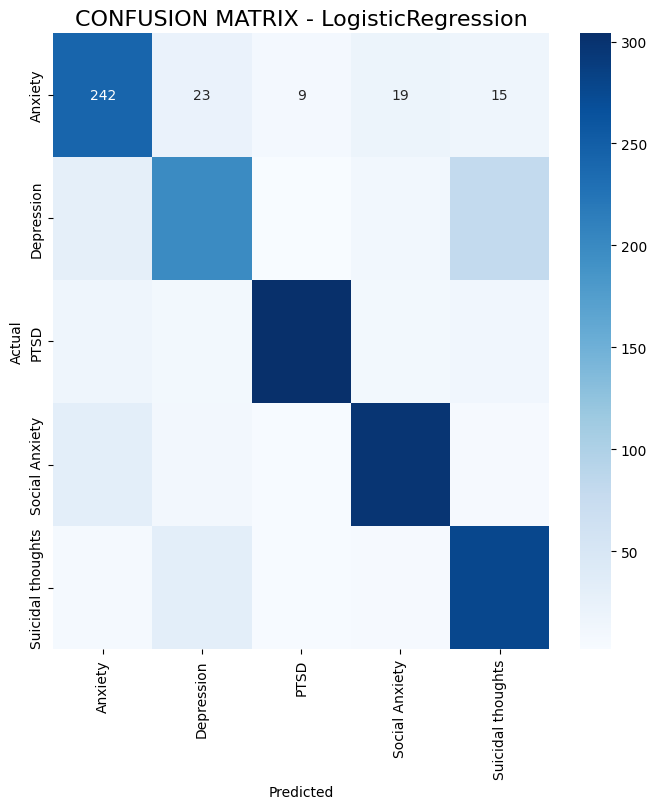

In [94]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.topics.values, 
            yticklabels=category_id_df.topics.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression", size=16);

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,  random_state = 0)                                             

In [96]:
#FE
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
model = LogisticRegression().fit(tfidf_vectorizer_vectors, y_train)


In [97]:
inputs = """Does anyone else get depressive thoughts and immediately hate yourself for them after? Whenever I think depressive thoughts like "your friends are all pulling away from you because they don't need you" or "Everyone is better off without you because you're such a burden" or whatever else, those thoughts are immediately followed by thoughts about how I'm stupid and selfish and childish for wallowing in pity and I should just suck it up because I need to grow up and realize that it's not all about me. 

It feels like a cycle that only ever makes me feel worse, especially about trying to reach out and have to burden someone else with my shit when they have their own shit going on. 

I couldn't even go to a second therapy session because I felt guilty for taking up the time of those who have to drive me there, and for taking up time from the counselor that could be used for someone that needed it a lot more.

Does anyone else get like this?"""
print(model.predict(fitted_vectorizer.transform([inputs])))

['Depression']


In [48]:
result = """Does anyone else get depressive thoughts and immediately hate yourself for them after? Whenever I think depressive thoughts like "your friends are all pulling away from you because they don't need you" or "Everyone is better off without you because you're such a burden" or whatever else, those thoughts are immediately followed by thoughts about how I'm stupid and selfish and childish for wallowing in pity and I should just suck it up because I need to grow up and realize that it's not all about me. 

It feels like a cycle that only ever makes me feel worse, especially about trying to reach out and have to burden someone else with my shit when they have their own shit going on. 

I couldn't even go to a second therapy session because I felt guilty for taking up the time of those who have to drive me there, and for taking up time from the counselor that could be used for someone that needed it a lot more.

Does anyone else get like this?"""
print(model.predict(fitted_vectorizer.transform([result])))

['Depression']


In [49]:
result="""Is this as bad as I think it is Hi! So I was talking with a group of coworkers on my way back from lunch. We're all just minor acquaintances, not good friends. They were covering me. 

When the convo came to an end, as they were leaving, I was thinking of something 
to say so it wasn't an awkwardly silent departure. Well, my dumb brain made me say "thanks again, you two!!" 
and i can't stop thinking about it lmao. It sounded so bad and awkward yikes. "YOU TWO"? wtf self """
print(model.predict(fitted_vectorizer.transform([result])))

['Social Anxiety']


In [50]:
result="""Doing risky or self-destructive things, such as using drugs or driving recklessly
Giving away belongings or getting affairs in order when there's no other logical explanation for doing this"""
print(model.predict(fitted_vectorizer.transform([result])))

['Suicidal thoughts']


In [51]:
result="""Recurrent, unwanted distressing memories of the traumatic event
Reliving the traumatic event as if it were happening again (flashbacks)
Upsetting dreams or nightmares about the traumatic event
Severe emotional distress or physical reactions to something that reminds you of the traumatic event"""
print(model.predict(fitted_vectorizer.transform([result])))

['PTSD']
